In [103]:
data='../data/'
rep='ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE142nnn/age/matrix//GSE142439_series_matrix.txt.gz'
epic_man='https://webdata.illumina.com/downloads/productfiles/methylationEPIC/infinium-methylationepic-v-1-0-b5-manifest-file-csv.zip'
horvath='https://static-content.springer.com/esm/art%3A10.1186%2Fgb-2013-14-10-r115/MediaObjects/13059_2013_3156_MOESM3_ESM.csv'
fib_age='https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-020-15174-3/MediaObjects/41467_2020_15174_MOESM5_ESM.xlsx'
fib_treat='https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-020-15174-3/MediaObjects/41467_2020_15174_MOESM9_ESM.xlsx'
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [104]:
!wget -q -nc {rep} -O {data}\rep.txt.gz
!wget -q -nc {epic_man} -O {data}\epic.csv.zip
!wget -q -nc {horvath} -O {data}\horvath.csv

In [105]:
df=pd.read_csv(data+'rep.txt.gz',sep='\t',skiprows=71,index_col=0) # methylation data starts from line 71
df=df.drop('!series_matrix_table_end')
meta=pd.read_csv(data+'rep.txt.gz',sep='\t',skiprows=40,index_col=0,nrows=3) # meta data starts from line 40
meta.columns=df.columns
meta.index=['age','cell','treatment']
meta=meta.T
meta['age']=meta.age.str.strip('age: ')
meta['cell']=meta.cell.str.strip('cell type: ')
meta['treatment']=meta.treatment.str.strip('treatmentstatus: ')
meta['t']=meta.treatment.apply(lambda x: 1 if x=='Normal' else 0)
meta['cell']=meta.cell.apply(lambda x: 'skin' if x=='skin fibroblasts' else 'vein')
meta.T

,GSM4227385,GSM4227386,GSM4227387,GSM4227388,GSM4227389,GSM4227390,GSM4227391,GSM4227392,GSM4227393,GSM4227394,GSM4227395,GSM4227396,GSM4227397,GSM4227398,GSM4227399,GSM4227400
age,61,61,61,61,69,69,67,67,48,48,47,47,49,49,49,49
cell,skin,skin,skin,skin,skin,skin,skin,skin,vein,vein,vein,vein,vein,vein,vein,vein
treatment,Normal,Treated,Normal,Treated,Normal,Treated,Normal,Treated,Normal,Treated,Normal,Treated,Normal,Treated,Normal,Treated
t,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0


In [106]:
df[meta[(meta.cell=='skin')].index].round(2).to_csv(data+'meth.csv')

In [107]:
for tissue in ['skin','vein']:
    df[tissue+'_normal']=df[meta[(meta.cell==tissue)&(meta.treatment=='Normal')].index].mean(1)
    df[tissue+'_treated']=df[meta[(meta.cell==tissue)&(meta.treatment=='Treated')].index].mean(1)
    df[tissue+'_dif']=df[tissue+'_treated']-df[tissue+'_normal']
df.head(1)

,GSM4227385,GSM4227386,GSM4227387,GSM4227388,GSM4227389,GSM4227390,GSM4227391,GSM4227392,GSM4227393,GSM4227394,...,GSM4227397,GSM4227398,GSM4227399,GSM4227400,skin_normal,skin_treated,skin_dif,vein_normal,vein_treated,vein_dif
ID_REF,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.192582,0.22964,0.084506,0.102028,0.202294,0.170894,0.185225,0.229188,0.19241,0.152512,...,0.358765,0.366739,0.446669,0.433033,0.166152,0.182937,0.016786,0.451154,0.454321,0.003167


<AxesSubplot:>

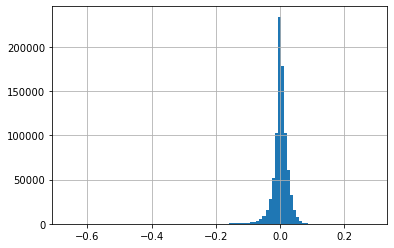

In [108]:
df.skin_dif.hist(bins=100)

<AxesSubplot:>

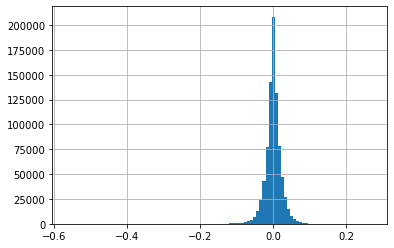

In [159]:
df.vein_dif.hist(bins=100)

In [109]:
epic=pd.read_csv(data+'epic.csv.zip',skiprows=7,index_col=0) # data starts from line 7
epic['Relation_to_UCSC_CpG_Island']=epic.Relation_to_UCSC_CpG_Island.fillna('Open Sea')
epic['450k_Enhancer']=epic['450k_Enhancer'].fillna('False')
epic=epic.replace({'Relation_to_UCSC_CpG_Island': {'N_Shore': 'Shore or Shelf', 'S_Shore': 'Shore or Shelf','N_Shelf':'Shore or Shelf',
                                              'S_Shelf':'Shore or Shelf'}})
epic['ch']=pd.to_numeric(epic.CHR,errors='coerce')
epic = epic[epic['ch'].notna()]
epic['g']=epic.ch*10**9+epic['MAPINFO']
epic.shape

/Users/mahdimoqri/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2,4,42,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(846232, 53)

In [110]:
df=df.merge(epic,left_index=True,right_index=True)

In [210]:
dg=df[np.abs(df.skin_dif)>.4]
dg.shape

(159, 75)

In [212]:
skins=dg.index

In [213]:
dg=df[np.abs(df.vein_dif)>.3]
dg.shape

(209, 75)

In [214]:
veins=dg.index

In [216]:
len(skins.intersection(veins))

40

In [164]:
dgh=dg[['CHR_hg38','Start_hg38','End_hg38','Strand_hg38']]
dgh['Start_hg38']=dgh.Start_hg38.astype(int)
dgh['End_hg38']=dgh.End_hg38.astype(int)
dgh.reset_index(inplace=True,drop=True)
dgh.to_csv(data+'dmh.txt',sep='\t')
dgh.head(1)

/Users/mahdimoqri/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mahdimoqri/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,CHR_hg38,Start_hg38,End_hg38,Strand_hg38
0,chr11,122668916,122668918,-


Text(0, 0.5, 'Treatment effect (treated - normal) ')

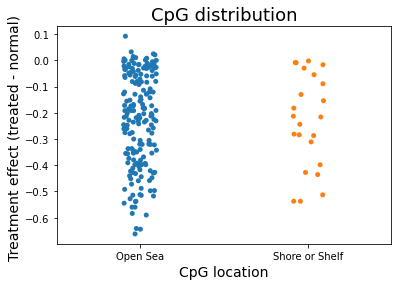

In [169]:
sns.stripplot(data=dg,x='Relation_to_UCSC_CpG_Island',y='vein_dif')
plt.title('CpG distribution', fontsize=18)
plt.xlabel('CpG location', fontsize=14)
plt.ylabel('Treatment effect (treated - normal) ', fontsize=14)

Text(0, 0.5, 'Percentage of CpGs')

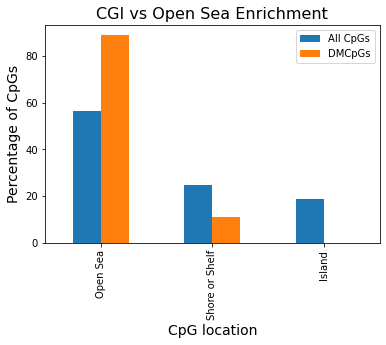

In [166]:
epic_count=epic['Relation_to_UCSC_CpG_Island'].value_counts()/len(epic)*100
dg_count=dg['Relation_to_UCSC_CpG_Island'].value_counts()/len(dg)*100
cgi=pd.concat([epic_count, dg_count], axis=1)
cgi.columns=['All CpGs','DMCpGs']
cgi.plot(kind='bar')
plt.title('CGI vs Open Sea Enrichment', fontsize=16)
plt.xlabel('CpG location', fontsize=14)
plt.ylabel('Percentage of CpGs', fontsize=14)

Text(0, 0.5, 'Percentage of CpGs')

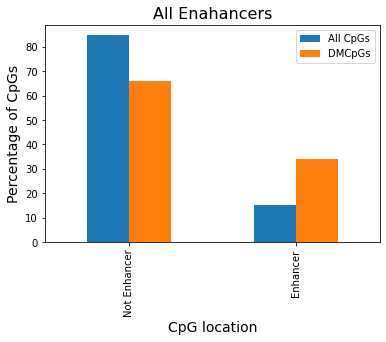

In [167]:
epic_count=epic['450k_Enhancer'].value_counts()/len(epic)*100
dg_count=dg['450k_Enhancer'].value_counts()/len(dg)*100
enhancer=pd.concat([epic_count, dg_count], axis=1)
enhancer.columns=['All CpGs','DMCpGs']
enhancer.index=['Not Enhancer','Enhancer']
enhancer.plot(kind='bar')
plt.title('All Enahancers', fontsize=16)
plt.xlabel('CpG location', fontsize=14)
plt.ylabel('Percentage of CpGs', fontsize=14)

In [157]:
bed='http://www.enhanceratlas.org/data/download/enhancer/hs/HSC.bed'
bed='http://www.enhanceratlas.org/data/download/enhancer/hs/Fibroblast_foreskin.bed'
enh=pd.read_csv(bed,sep='\t',header=None)
enh.shape

(40449, 4)

In [86]:
enh['ch']=enh[0].str.strip('chr')
enh['ch']=pd.to_numeric(enh.ch,errors='coerce')
enh=enh.dropna()
enh['gs']=(enh.ch*10**9+enh[1]).astype(int)
enh['ge']=(enh.ch*10**9+enh[2]).astype(int)

In [88]:
a=[]
for i,row in enh.iterrows():
    a.append(list(range(row['gs'],row['ge'])))
a=set().union(*a)
epic['enh']=epic.g.apply(lambda v: v in a)
dg['enh']=dg.g.apply(lambda v: v in a)

/Users/mahdimoqri/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [89]:
epic.enh.value_counts()/len(epic)

False    0.903138
True     0.096862
Name: enh, dtype: float64

In [90]:
dg.enh.value_counts()/len(dg)

False    0.835924
True     0.164076
Name: enh, dtype: float64

Text(0, 0.5, 'Percentage of CpGs')

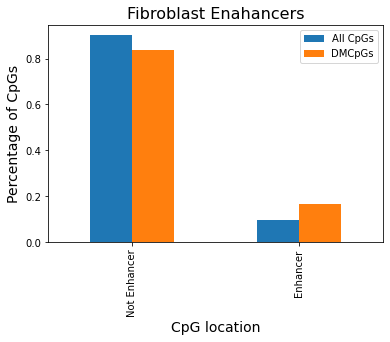

In [91]:
fibc=(pd.DataFrame([epic.enh.value_counts()/len(epic),dg.enh.value_counts()/len(dg)])).T
fibc.columns=['All CpGs','DMCpGs']
fibc.index=['Not Enhancer', 'Enhancer']
fibc.plot(kind='bar')
plt.title('Fibroblast Enahancers', fontsize=16)
plt.xlabel('CpG location', fontsize=14)
plt.ylabel('Percentage of CpGs', fontsize=14)

In [92]:
dg['450k_Enhancer'].value_counts()/len(dg)

False    0.680484
True     0.319516
Name: 450k_Enhancer, dtype: float64

In [93]:
dgc=dg[['450k_Enhancer','CHR']].groupby(['CHR','450k_Enhancer']).size().unstack()

In [94]:
dg.loc['cg27421918'].ch

22.0

In [95]:
dg[dg.ch==22].skin_dif

cg04317756   -0.310798
cg05843420   -0.358778
cg12510044   -0.344854
cg15999544   -0.383437
cg19803200   -0.345057
cg20520743   -0.407499
cg27377225   -0.420757
cg27421918   -0.349555
Name: skin_dif, dtype: float64

In [96]:
horv=pd.read_csv(data+'horvath.csv',index_col=0,skiprows=2)
horv=horv.merge(df[['skin_dif','vein_dif']],left_index=True,right_index=True)
horv['skin_effect']=(horv.CoefficientTraining*horv.skin_dif)*21
horv['vein_effect']=(horv.CoefficientTraining*horv.vein_dif)*21

/Users/mahdimoqri/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Years')

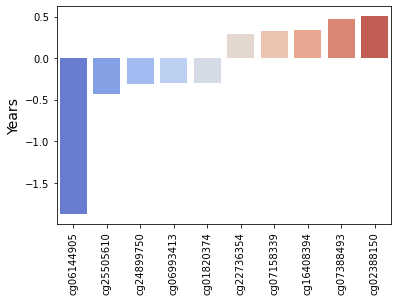

In [97]:
skin=pd.concat([horv.skin_effect.sort_values()[:5],horv.skin_effect.sort_values()[-5:]])
sns.barplot(skin.index,skin.values,palette=("coolwarm"))
plt.xticks(rotation=90);
plt.ylabel('Years', fontsize=14)

/Users/mahdimoqri/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Years')

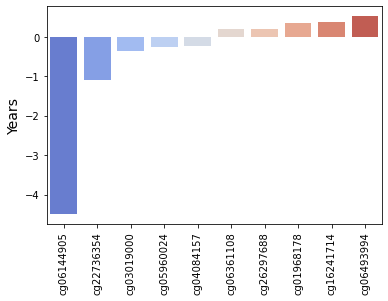

In [98]:
vein=pd.concat([horv.vein_effect.sort_values()[:5],horv.vein_effect.sort_values()[-5:]])
sns.barplot(vein.index,vein.values,palette=("coolwarm"))
plt.xticks(rotation=90);
plt.ylabel('Years', fontsize=14)

In [99]:
topcg=df.loc[horv.sort_values('vein_effect').index[0]][['CHR','MAPINFO']]
topcg=df[(df.CHR=='17')&(df.MAPINFO>=topcg.MAPINFO)&(df.MAPINFO<topcg.MAPINFO+400)].sort_values("MAPINFO")[['skin_dif','vein_dif']]
topcg

,skin_dif,vein_dif
cg06144905,-0.149459,-0.358302
cg02463253,-0.032011,-0.012339
cg00016913,-0.178758,-0.057542
cg22968401,-0.134953,-0.014891
cg17751776,-0.016066,-0.002674


Text(0, 0.5, 'Methylation')

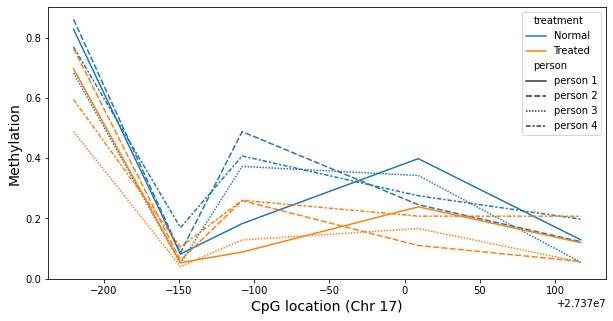

In [100]:
PIPOX=df.loc[topcg.index].T.merge(meta[meta.cell=='skin'][['treatment']],left_index=True,right_index=True)
PIPOX.columns=['mapinfo_'+ str(b) for b in df.loc[topcg.index].MAPINFO.astype(int).values]+['treatment']
PIPOX['person']=['person 1','person 1','person 2','person 2','person 3','person 3','person 4','person 4']
PIPOX['id']=PIPOX.reset_index().index
p=pd.wide_to_long(PIPOX,'mapinfo_','id','i')
p['CpG']=p.index.get_level_values(1)
p['cg']=p['mapinfo_'].astype(float)
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=p,x='CpG',y='cg',style='person',hue='treatment')
plt.xlabel('CpG location (Chr 17)', fontsize=14)
plt.ylabel('Methylation', fontsize=14)


Text(0, 0.5, 'Methylation')

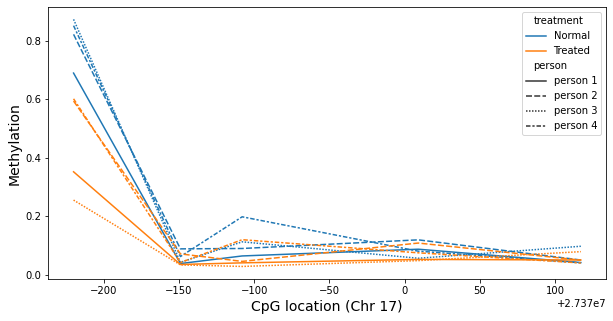

In [101]:
PIPOX=df.loc[topcg.index].T.merge(meta[meta.cell=='vein'][['treatment']],left_index=True,right_index=True)
PIPOX.columns=['mapinfo_'+ str(b) for b in df.loc[topcg.index].MAPINFO.astype(int).values]+['treatment']
PIPOX['person']=['person 1','person 1','person 2','person 2','person 3','person 3','person 4','person 4']
PIPOX['id']=PIPOX.reset_index().index
p=pd.wide_to_long(PIPOX,'mapinfo_','id','i')
p['CpG']=p.index.get_level_values(1)
p['cg']=p['mapinfo_'].astype(float)
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=p,x='CpG',y='cg',style='person',hue='treatment')
plt.xlabel('CpG location (Chr 17)', fontsize=14)
plt.ylabel('Methylation', fontsize=14)

In [36]:
fiba=pd.read_excel(fib_age,index_col=0).drop('Gene Name').iloc[:,0:2]
fibt=pd.read_excel(fib_treat,index_col=0).drop('Gene Name').iloc[:,0:2]
fibt.index=fibt.index.str.strip()
fibt.columns=['n','t']

/Users/mahdimoqri/miniconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [37]:
genes=pd.read_csv(data+'genes.txt',index_col=1)

In [38]:
genes=genes.merge(fibt,left_index=True,right_index=True)
for gene in ['GSM4227385','GSM4227387','GSM4227389','GSM4227391']:
    genes[gene]=genes.n
for gene in ['GSM4227386','GSM4227388','GSM4227390','GSM4227392']:
    genes[gene]=genes['t']
genes.index=genes['Gene stable ID']
genes=genes.drop(['Gene stable ID','n','t'],1)

In [39]:
genes.drop_duplicates().round(2).to_csv(data+'exp.csv')

In [40]:
fiba.columns=['a','ap']
fibt.columns=['t','tp']
fiba.index=fiba.index.str.strip()
fibt.index=fibt.index.str.strip()

<AxesSubplot:xlabel='a', ylabel='t'>

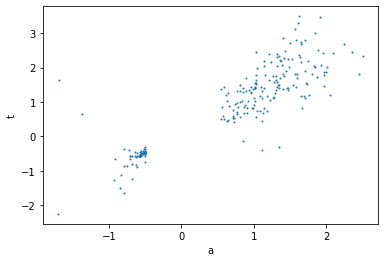

In [41]:
fib=fiba.merge(fibt,left_index=True,right_index=True)
fib.plot.scatter('a','t',s=1)

In [34]:
gene=df.loc['cg06144905','UCSC_RefGene_Name']
gene

'PIPOX'

In [72]:
fibt.sort_values('t').tail(20)

,t,tp
Treated vs Aged Gene Signature in Fibroblasts,,
RAB13,3.547830,0.019634
DPYSL3,3.551120,0.024221
TTC3P1,3.602380,0.000946
FRMD6,3.617459,0.001511
HIST1H2BK,3.788538,0.013145
CD55,3.796189,0.036328
SNHG6,3.798748,0.013995
HIST1H1C,3.836446,0.028709
CTHRC1,3.885259,0.036153


In [57]:
fib.sort_values('a').tail(50)[['a','t']]

,a,t
RALGDS,1.465867,1.420238
ZNF771,1.467403,1.339228
C7orf55,1.477313,2.235251
ZFAND1,1.485859,2.018548
PABPC1L,1.501997,2.721705
TMA7,1.520852,2.238327
RBBP6,1.543401,1.483416
FAM126A,1.562336,3.112907
PCCB,1.564690,1.806259
SNORD2,1.581071,1.446196


In [42]:
dg.shape

(7404, 76)

In [37]:
tss=pd.read_csv(data+'tss38.gz',sep='\t',index_col=0)
tss=tss.drop_duplicates()
tss.index=tss['name2']

In [38]:
fibtg=fibt.merge(tss,left_index=True,right_index=True)

In [39]:
fibtg['l']=(fibtg.txEnd-fibtg.txStart)
fibtg['ch']=fibtg.chrom.str.strip('chr')
fibtg['ch']=pd.to_numeric(fibtg.ch,errors='coerce')
fibtg=fibtg.dropna()

In [40]:
fibtg['gs']=(fibtg.ch*10**9+fibtg.txStart).astype(int)
fibtg['ge']=(fibtg.ch*10**9+fibtg.txEnd).astype(int)

In [41]:
fibtg=fibtg[fibtg.l<10**6]

In [42]:
a=[]
for i,row in fibtg.iterrows():
    a.append(range(row['gs'],row['ge']))

KeyboardInterrupt: 

In [ ]:
a=set().union(*a)

In [ ]:
len(a)

In [ ]:
dg['ch']=dg.CHR_hg38.str.strip('chr')
dg['ch']=pd.to_numeric(dg.ch,errors='coerce')
dg['g']=dg.ch*10**9+dg.Start_hg38

In [ ]:
dg['i']=dg.g.apply(lambda x:x in a)

In [ ]:
dg[(dg.i)&(dg['450k_Enhancer'])]

In [ ]:
dg.shape